# Creating a basic Cluster Expansion

In [1]:
import numpy as np
import json
from monty.serialization import loadfn, dumpfn
from pymatgen import Structure
from smol.cofe import ClusterSubspace, StructureWrangler, ClusterExpansion
from smol.cofe.extern import EwaldTerm
from smol.io import load_work, save_work
from smol.optimization.ce_Bayes_opt import *
from smol.optimization.adds_on import *

# Load a cluster expansion file from previous saved one

In [2]:

work = load_work('./data/LMTO_sinusoid.mson')
for name, obj in work.items():
    print(f'{name}: {type(obj)}\n')

StructureWrangler: <class 'smol.cofe.wrangler.StructureWrangler'>

ClusterExpansion: <class 'smol.cofe.expansion.ClusterExpansion'>



In [3]:
wrangler = work['StructureWrangler']
ce = work['ClusterExpansion']

#  Training part

Training a cluster expansion is one of the most critical steps. 

Training with Bayesian regression typically requires the correlation vector to be represented in orthogonal basis.
Indicator basis is not appropriate for Bayesian regression

In [4]:
wrangler.feature_matrix

array([[ 1.        , -0.25      ,  0.4330127 , ...,  0.03222656,
        -0.02283465,  0.01757812],
       [ 1.        , -0.25      ,  0.4330127 , ...,  0.03125   ,
        -0.01776029,  0.02636719],
       [ 1.        , -0.25      ,  0.4330127 , ...,  0.0703125 ,
        -0.02029747,  0.        ],
       ...,
       [ 1.        , -0.4375    , -0.10825318, ..., -0.01041667,
         0.        ,  0.        ],
       [ 1.        , -0.4375    , -0.10825318, ..., -0.04166667,
         0.        ,  0.        ],
       [ 1.        , -0.4375    , -0.10825318, ...,  0.02083333,
         0.        ,  0.        ]])

In [5]:
"""
Different from pyabinitio, normalized refers to the original data whether normalzied. So the key
total_energy here is actually normalized.
"""

wrangler.get_property_vector('total_energy')

array([-13.11874117, -13.12903802, -13.17137952, -13.08021449,
       -13.16362834, -13.10222821, -13.08156161, -13.15720459,
       -13.06331364, -13.12062745, -13.17905239, -13.12440631,
       -13.17411988, -13.20385514, -13.10332586, -13.12882567,
       -13.13764792, -13.14550215, -13.1109768 , -13.13433355,
       -13.08290429, -13.15571512, -13.12275268, -13.15715223,
       -13.09132904, -13.08556145, -13.03954859, -13.12791847,
       -13.12750551, -13.08865104, -13.05968182, -13.13590795,
       -13.1004459 , -13.17690217, -13.14593605, -13.11400736,
       -13.12124423, -13.14953541, -13.12336135, -13.13870288,
       -13.14821189, -13.02921938, -13.10899456, -13.01145925,
       -13.02529022, -13.09379601, -13.13166383, -13.06279359,
       -13.11696813, -13.13820625, -13.07975418, -12.97458318,
       -13.1316143 , -13.11638331, -13.15155213, -13.0794376 ,
       -13.13064402, -13.15555385, -13.12331726, -13.10800658,
       -13.01404902, -13.00900896, -13.09916021, -13.10

# Optimization of ridge regularization in Li-Mn-Ti-O system

In [6]:
coefs_ridge = ridge_optimize(A=wrangler.feature_matrix, 
                   f= wrangler.get_property_vector('total_energy'), 
                   mu = 1e-4)

print(coefs_ridge)

[-11.92439871   4.68735753  -0.23787396   0.74980824  -0.46459773
   0.14105951   0.43117229  -0.19676567   0.0542778    0.18090402
   0.19251365  -0.11920026   0.13823426   0.07085491  -0.03708378
   0.23008805  -0.11591784  -0.01576551  -0.26739028  -0.06974138
   0.44250468   0.06094559  -0.07070943  -0.09513262   0.28059894
   0.1189496   -0.11077483]


# Optimization of Bayesian regularization in Li-Mn-Ti-O system

In [7]:
opt_gamma, regu = get_optimal_gamma(subspace=ce.cluster_subspace, 
                                    A=wrangler.feature_matrix, 
                                    f= wrangler.get_property_vector('total_energy'),
                                    if_Ewald= False)

cov = np.diag(regu)


In [10]:
cov.shape

(27, 27)

In [11]:
wrangler.feature_matrix.shape

(630, 27)

In [12]:
coefs_Bayes = Bayes_optimize(A=wrangler.feature_matrix, 
                   f= wrangler.get_property_vector('total_energy'), 
                   cov = cov)

print(coefs_Bayes)

[-1.25040205e+01  3.22392684e+00  3.41565511e-01  8.02704723e-01
 -2.84795487e-01  1.18788949e-02  4.17343382e-01 -1.85998753e-01
  5.36182502e-02  1.52883253e-01  2.08307588e-01 -1.23896961e-01
  1.30504228e-01  7.90317686e-02 -4.76187594e-02  2.05094443e-01
 -8.54556269e-02 -1.88612051e-02 -1.98668701e-01  9.95106028e-02
  1.39735927e-01  1.21256886e-02 -5.00197735e-02 -3.49013485e-02
  1.01629257e-01  5.11382017e-02  1.95112930e-02]


# Comparison of ridge and Bayesian regression in Li-Mn-Ti-O system

Non-zero ECIs in ridge:  27
Non-zero ECIs in Bayesian:  27


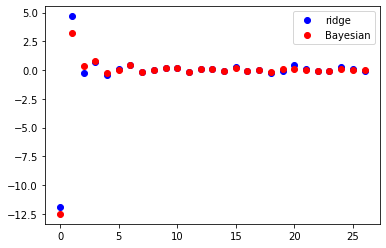

In [14]:
plt.plot(coefs_ridge, 'o', color = 'b',label = 'ridge')
plt.plot(coefs_Bayes, 'o',color = 'r', label = 'Bayesian')
plt.legend()


print("Non-zero ECIs in ridge: ", np.sum(np.abs(coefs_ridge)>1e-6))
print("Non-zero ECIs in Bayesian: ", np.sum(np.abs(coefs_Bayes)>1e-6))

### 4) The cluster expansion
Now we can use the above work to create the `ClusterExpansion`. The cluster expansion can be used to predict the fitted property for new structures, either for testing quality or for simulations such as in Monte Carlo.
Note that when using the `predict` function, the cluster expansion will have to match the given structure if it has not seen it before.

In [15]:
expansion = ClusterExpansion(ce.cluster_subspace,
                             coefficients=coefs_Bayes,
                             feature_matrix=wrangler.feature_matrix)

structure = np.random.choice(wrangler.structures)
prediction = expansion.predict(structure, normalize=True)

print(f'The predicted energy for a structure with composition '
      f'{structure.composition} is {prediction} eV/prim.\n')
print(f'The fitted coefficients are:\n{expansion.coefs}\n')
print(f'The effective cluster interactions are:\n{expansion.eci}\n')
print(expansion)

The predicted energy for a structure with composition Li+20 Mn3+12 Ti4+4 O2-36 is -13.396567212777944 eV/prim.

The fitted coefficients are:
[-1.25040205e+01  3.22392684e+00  3.41565511e-01  8.02704723e-01
 -2.84795487e-01  1.18788949e-02  4.17343382e-01 -1.85998753e-01
  5.36182502e-02  1.52883253e-01  2.08307588e-01 -1.23896961e-01
  1.30504228e-01  7.90317686e-02 -4.76187594e-02  2.05094443e-01
 -8.54556269e-02 -1.88612051e-02 -1.98668701e-01  9.95106028e-02
  1.39735927e-01  1.21256886e-02 -5.00197735e-02 -3.49013485e-02
  1.01629257e-01  5.11382017e-02  1.95112930e-02]

The effective cluster interactions are:
[-1.25040205e+01  3.22392684e+00  3.41565511e-01  1.33784120e-01
 -4.74659146e-02  1.97981581e-03  1.39114461e-01 -6.19995845e-02
  1.78727501e-02  1.27402711e-02  1.73589656e-02 -1.03247468e-02
  2.17507047e-02  1.31719614e-02 -7.93645989e-03  1.70912036e-02
 -7.12130224e-03 -1.57176710e-03 -2.48335877e-02  1.24388253e-02
  1.74669909e-02  1.51571108e-03 -2.50098867e-02 -1.7

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
